In [1]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
griddef = gs.GridDef(griddef="100 0 1 \n100 0 1 \n1 0.5 1")
griddef

Pygeostat GridDef:
100 0.0 1.0 
100 0.0 1.0 
1 0.5 1.0

# Data Columns

In [9]:
def open_vmodel(vmodel_file,n_variograms,n_lag):
    list_ = []
    index = []
    vargplot = open(vmodel_file)
    for i in range(n_variograms):
        vargplot.readline()
        for i in range(n_lag):
            dm = vargplot.readline().split()
            list_.append(list(map(float,dm))) 
    result = pd.DataFrame(list_)
    result.columns = ['Variogram Index','Lag Distance','Variogram Value','3','4','5']
    istart = 0
    for i in range(n_variograms):
        result['Variogram Index'][istart:istart+n_lag] = i+1
        istart +=  n_lag
        
    return pd.DataFrame(result)

# Prediction of the Azimuth 

In [10]:
Pred_list = []

for i in range(21):
    g = gs.DataFile ('IDW_Rot_WL_all_V/IDW_walker_all_V_{}.out'.format (i))['Estimate']
    Pred_list.append (g)

In [1]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
model_azimuth = load_model('CNN_A_Azimuth.h5')


In [13]:
from scipy.sparse import coo_matrix

In [31]:
data = gs.DataFile('10addcoord1.out')
row, col = data['X'], data['Y']

Pred_list_2 = [coo_matrix((Pred_list[i], (row, col)), shape=(100, 100)).toarray() for i in range(21)]
X_train = np.array(Pred_list_2).reshape(21, 100, 100, 1)

Pred_Azimuth_U = model_azimuth.predict(X_train)

sin_w = [Pred_Azimuth_U[i][0] for i in range(21)]
cos_w = [Pred_Azimuth_U[i][1] for i in range(21)]

tan_w = [sin_w[i] / cos_w[i] for i in range(21)]
arctan_w = [np.arctan(tan_w[i]) for i in range(21)]

pred_w = [(arctan_w[i]/np.pi) * 180 for i in range(21)]

for i in range(21):
    if cos_w[i] > 0 and sin_w[i] > 0:
        pass
    elif cos_w[i] < 0 and sin_w[i] > 0:
        pred_w[i] = 180 + pred_w[i]
    elif cos_w[i] < 0 and sin_w[i] < 0:
        pred_w[i] = 180 + pred_w[i]
    else:
        pred_w[i] = 360 + pred_w[i]

pred = [pred_w[i]/2 for i in range(21)]
pred_mean = np.mean(np.array(pred))

print(pred_mean)


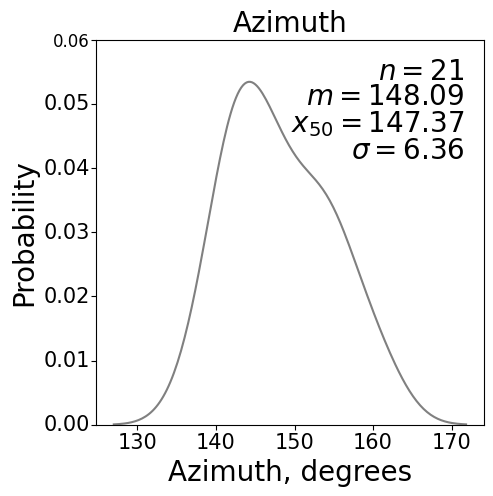

In [40]:
params = {'legend.fontsize': 'large', 'axes.labelsize': 'large', 'axes.titlesize':'large',
         'xtick.labelsize':'large', 'ytick.labelsize':'large'}
pylab.rcParams.update (params)
fig,ax1= plt.subplots(figsize=(5,5))
sns.kdeplot(pred,color = 'grey',alpha = 0.1,levels = 1,bw_adjust = 1,shade=False)
# plt.axvline(25.59,c='black',linestyle="--")
gs.histogram_plot(pred,ax=ax1 , lw=0,stat_fontsize=20,stat_blk='minimal',color='white',bins=100 )
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
ax1.set_xlabel('Azimuth, degrees',fontsize=20);
ax1.set_ylabel('Probability',fontsize=20);
ax1.set_title('Azimuth',fontsize=20);
ax1.set_ylim(0, 0.06)  # Set y-limit here
plt.savefig ('Azimuth_U.svg', bbox_inches = 'tight', dpi = 300)
plt.show()
